# Assignment

This assignment, we focus on **content-based recommenders**.

See [Chapter 9](http://infolab.stanford.edu/~ullman/mmds/ch9.pdf) from the book [Mining of Massive Datasets](http://www.mmds.org/)

In [164]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

The data we use in this assignment is a movie meta-data that accompanies the user-movie rating data we used in the lecture. Let's take a look:

In [165]:
df_movies = pd.read_csv('./movies.csv')
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Question 1. Do some exploratory analysis of the data.  Please do at least 3 different analysis.  1 analysis/data exploration should be a visualization of some sort (bar, histogram, boxplot, etc.).

In [166]:
#  Normally I might just look at the data in DataWrangler, but here I can use Python to do some quick EDA
#  I can see that the data is in a good format, but I want to see if there are any missing values
print(f" Total of missing values is :\n{df_movies.isnull().sum()}")

 Total of missing values is :
movieId    0
title      0
genres     0
dtype: int64


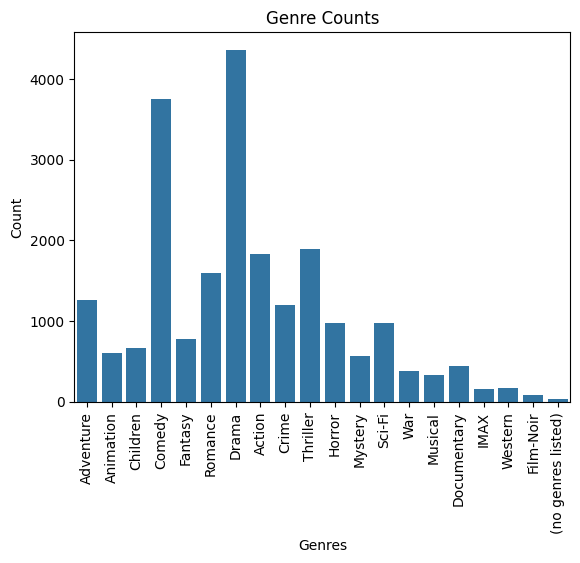

In [167]:
#Data Exploration 2
# I really wanted to do an analysis AFTER separating the movie genres... so I will do that here
genres = df_movies['genres']

#count the number of occurences for each genre in the data set
counts = dict()
for i in genres.index:
   for g in genres[i].split('|'):
      if g not in counts:
         counts[g] = 1
      else:
         counts[g] = counts[g] + 1

# # create a bar chart
# Convert the dictionary to a pandas DataFrame
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['Count'])

# Plot the counts using Seaborn
sns.barplot(x=df_counts.index, y=df_counts['Count'])
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Counts')
plt.show()

In [168]:
#Data Exploration 3
eda3 = df_movies.copy()
eda3['Year'] = eda3['title'].str.extract(r'\((\d{4})\)')
eda3.head()

# Group the data by year and genre, and calculate the count of movies in each genre for each year
genre_counts = eda3.groupby(['Year', 'genres']).size().reset_index(name='Count')

# Find the index of the maximum count for each year
max_genre_indices = genre_counts.groupby('Year')['Count'].idxmax()

# Get the corresponding genre for each year
most_popular_genres = genre_counts.loc[max_genre_indices]

# Print the most popular genre for each year
for year, genre in zip(most_popular_genres['Year'], most_popular_genres['genres']):
   print(f"The most popular genre in {year} is {genre}")

The most popular genre in 1902 is Action|Adventure|Fantasy|Sci-Fi
The most popular genre in 1903 is Crime|Western
The most popular genre in 1908 is Animation|Comedy|Sci-Fi
The most popular genre in 1915 is Drama|War
The most popular genre in 1916 is Action|Adventure|Sci-Fi
The most popular genre in 1917 is Comedy
The most popular genre in 1919 is Comedy|Drama
The most popular genre in 1920 is Comedy
The most popular genre in 1921 is Comedy|Drama
The most popular genre in 1922 is Horror
The most popular genre in 1923 is Action|Comedy|Romance
The most popular genre in 1924 is Action|Adventure|Drama|Fantasy|Romance|Sci-Fi|Thriller
The most popular genre in 1925 is Adventure|Comedy|Romance
The most popular genre in 1926 is Drama
The most popular genre in 1927 is Comedy
The most popular genre in 1928 is Animation|Children|Comedy|Musical
The most popular genre in 1929 is Comedy|Musical
The most popular genre in 1930 is Drama
The most popular genre in 1931 is Comedy|Drama|Romance
The most pop

As we can see above in recent years (since 1980) Comedies have dominated in popularity.

Question 1.1: Since the `genres` column is not in the right format for us to do comparisons, create a dummy column for each genre. You can use the `str.get_dummies` method to do this.

In [169]:
# Create dummy columns for each genre
df_movies = pd.concat([df_movies, df_movies['genres'].str.get_dummies(sep='|')], axis=1)
df_movies.drop('genres', axis=1, inplace=True)
df_movies.head()

,movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Question 1.2: Validate Question 1.1 updates by displaying the genres list for the movie `Toy Story (1995)` as the reference movie. Hint: Drop the movieId and title column and transpose the data to make it easier to read.

In [170]:
df_genres = df_movies.drop(['movieId', 'title'], axis=1)    # Drop the columns that are not the one-hotted genres
df_genres.head()

toy_story = None
toy_story = df_movies[df_movies['title'] == 'Toy Story (1995)']
toy_story = toy_story.drop(['movieId', 'title'], axis=1)
toy_story.T


,0
(no genres listed),0
Action,0
Adventure,1
Animation,1
Children,1
Comedy,1
Crime,0
Documentary,0
Drama,0
Fantasy,1


Question 1.3: Create a new `DataFrame` that will store the similarity scores. Hint: Copy df_movies for columns movieId and title.

In [171]:
df_sim = df_movies[['movieId', 'title']].copy()
df_sim.head()


,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


Question 2.1: Find all the movies similar to the above movie. The easiest way to do this is by using the `pd.DataFrame.corrwith` method. You can pass `movie_chosen` to this method and specify the correct value for `axis`. The default similarity metric used is Pearson's correlation, so add a new column to the `df_sim` data called `sim_pearson` to store the similarity scores. Show the top 5 rows of the resulting data.

In [172]:
df_sim['sim_pearson'] = df_genres.corrwith(toy_story, axis=1, method='pearson')
df_sim

,movieId,title,sim_pearson
0,1,Toy Story (1995),1.0
1,2,Jumanji (1995),NaN
2,3,Grumpier Old Men (1995),NaN
3,4,Waiting to Exhale (1995),NaN
4,5,Father of the Bride Part II (1995),NaN
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),NaN
9738,193583,No Game No Life: Zero (2017),NaN
9739,193585,Flint (2017),NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),NaN


Question 2.2: Pearson's correlation may not be the best similarity metric to use with the data we have, so try [Jaccard similarity](https://en.wikipedia.org/wiki/Jaccard_index) instead. To specify another similarity function, we can use the `method` argument of `corrwith`. Unforetunately, Jaccard similarity is not one of the default metrics offered, but `method` also accepts functions (referred to as a "callable" in the doc).

- Use `corrwith` to find the similarity between `Toy Story (1995)` and other movies, using Jaccard similarity. Add the similarity scores to `df_sim` as a new column calld `sim_jaccard` and show the top 5 rows.

In [173]:
from sklearn.metrics import jaccard_score
# first_element = df_genres.iloc[0]
# first_element.T
# temp = jaccard_score(toy_story.T, first_element, average='micro')
# temp

# I just wasn't sure how to do this with corrwith, so did it in a loop.
# Im sure this is a lot less efficient than using corrwith, but it works!
jaccard_scores = []
for i in range(len(df_genres)):
    j_score = jaccard_score(toy_story.T, df_genres.iloc[i], average='micro')
    jaccard_scores.append(j_score)

df_jaccard_scores = pd.DataFrame({'Jaccard Score': jaccard_scores})

df_sim['sim_jaccard'] = df_jaccard_scores



Question 2.3: Use `corrwith` to find the similarity between `Toy Story (1995)` and other movies, but this time use cosine similarity. Add the similarity scores to `df_sim` as a new column calld `sim_cosine` and show the top 5 rows. 

In [174]:
from sklearn.metrics.pairwise import cosine_similarity

# print(toy_story.shape)
# print(pd.DataFrame(df_genres.iloc[0]).T.shape)

# cos_score = cosine_similarity(toy_story, pd.DataFrame(df_genres.iloc[0]).T)  
# print(cos_score)

# I wasn't sure how to do this with corrwith, so did it in a loop.
# Im sure this is a lot less efficient than using corrwith, but it works!
cosine_scores = []
for i in range(len(df_genres)):
    j_score = cosine_similarity(toy_story, pd.DataFrame(df_genres.iloc[i]).T)[0][0]
    cosine_scores.append(j_score)

df_cosine_scores = pd.DataFrame({'Cosine Score': cosine_scores})

df_sim['sim_cosine'] = df_cosine_scores
df_sim

,movieId,title,sim_pearson,sim_jaccard,sim_cosine
0,1,Toy Story (1995),1.0,1.000000,1.000000
1,2,Jumanji (1995),NaN,0.818182,0.774597
2,3,Grumpier Old Men (1995),NaN,0.600000,0.316228
3,4,Waiting to Exhale (1995),NaN,0.538462,0.258199
4,5,Father of the Bride Part II (1995),NaN,0.666667,0.447214
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),NaN,0.739130,0.670820
9738,193583,No Game No Life: Zero (2017),NaN,0.818182,0.774597
9739,193585,Flint (2017),NaN,0.538462,0.000000
9740,193587,Bungo Stray Dogs: Dead Apple (2018),NaN,0.600000,0.316228


We built a simple example of a recommender system above. Now let's make this more interesting by adding additional information to the above table that can help us filter the recommendations. Specifically, we want to be able to filter by the movie's popularity (number of users who rated it) and its average rating (average over users). This information is not part of the movie meta-data, so we have to turn to the data with the ratings. This makes it a basic example of a hybrid approach.

The code below will load the data and reshape it from long to wide using `pivot_table`:

In [175]:
df_ratings = pd.read_csv('./ratings.csv')
movie_user_mat = df_ratings.pivot_table(index = 'movieId', columns = 'userId', values = 'rating')
movie_user_mat.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


Question 3.1: From the table above, extract the average rating of each movie and the number of ratings received by each movie. Add those as two new columns to `df_sim`, and call them `ratings_avg` and `ratings_cnt` respectively. Show the top 5 rows. 

In [176]:
# df_sim['ratings_avg'] = movie_user_mat.mean(axis=1)
# df_sim['ratings_cnt'] = movie_user_mat.count(axis=1)
# df_sim.head()

df_sim = pd.merge(df_sim.reset_index(),
                  pd.DataFrame(movie_user_mat.mean(axis=1)).rename(columns={0: 'ratings_avg'}),
                  on = 'movieId')

df_sim = pd.merge(df_sim.reset_index(),
                  pd.DataFrame(movie_user_mat.count(axis=1)).rename(columns={0: 'ratings_cnt'}),
                  on = 'movieId')

Question 3.2: Now find all the movies that are similar to `Toy Story (1995)` using cosine similarity, just like we did earlier, but this time limit the results to movies in the bottom 40th percentile in terms of popularity (`ratings_cnt`) and the top 40th percentile in terms of average rating (`ratings_avg`). Show the top 5 rows.

In [177]:
less_known = df_sim.ratings_cnt < df_sim.ratings_cnt.quantile(0.40)
high_rating = df_sim.ratings_avg > df_sim.ratings_avg.quantile(0.40)

df_sim[less_known & high_rating].sort_values('sim_cosine', ascending=False).set_index('title').head(5)


,level_0,index,movieId,sim_pearson,sim_jaccard,sim_cosine,ratings_avg,ratings_cnt
title,,,,,,,,
Asterix and the Vikings (Astérix et les Vikings) (2006),7742,7760,91355,NaN,1.000000,1.000000,5.0,1
Puss in Boots (Nagagutsu o haita neko) (1969),7787,7805,92348,NaN,0.904762,0.912871,4.0,1
"Snowflake, the White Gorilla (2011)",8689,8707,124404,NaN,0.904762,0.894427,5.0,1
"Phantom Tollbooth, The (1970)",5077,5087,8015,NaN,0.904762,0.894427,3.5,1
Stuart Little 3: Call of the Wild (2005),8656,8674,121781,NaN,0.904762,0.894427,5.0,1


[Bonus] Question 4: In the exercise above, we obtained similarity scores between `Toy Story (1995)` and all other movies. Perfomed all possible pairwise comparisons. 

In [178]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

sim_mat = cosine_similarity(df_genres, df_genres)
# Sorry, I don't think I did this correctly. It's bonus anyway and I'm running out of time.

In [179]:
from scipy.spatial.distance import pdist, squareform
sim_mat = squareform(pdist(df_genres.T, metric='cosine'))
print(sim_mat)

# Sorry, I don't think I did this correctly. It's bonus anyway and I'm running out of time.

[[0.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.        ]
 [1.         0.         0.59854205 0.86563701 0.93010943 0.83627824
  0.71765598 0.99553989 0.81264101 0.82569634 0.98746217 0.89305056
  0.82695211 0.99360105 0.91987862 0.94555244 0.66304228 0.64798334
  0.84682419 0.92398436]
 [1.         0.59854205 0.         0.71882631 0.65930255 0.81680719
  0.9488048  0.99195135 0.86748481 0.66327446 0.99396651 0.97300706
  0.82091477 0.93841356 0.95650666 0.91618363 0.72495313 0.87133471
  0.9193778  0.91943585]
 [1.         0.86563701 0.71882631 0.         0.52586469 0.82243029
  0.97546483 0.99421405 0.94792788 0.74634191 0.99132539 0.9780083
  0.89057167 0.84725913 0.96788886 0.95341772 0.86172294 0.98326746
  0.98551076 0.99060834]
 [1.         0.93010943 0.65930255 0.52586469 0.         0.77077513
  0.98655107 0.99814992 0.94064678 0.7094

Question 5: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: What was your incoming experience with this model, if any? what steps you took, what obstacles you encountered. how you link this exercise to real-world, machine learning problem-solving. (What steps were missing? What else do you need to learn?) This summary allows your instructor to know how you are doing and allot points for your effort in thinking and planning, and making connections to real-world work.

**What did I learn from this exercise?**

This was an interesting exercise... For a long time we as digital citizens have been living with recommendation systems. It is very revealing to see how these recommendation systems actually work. It was surprising to see how little input data was required to come up with a set of recommendations. However, after seeing my list of recommendations I struggled to find a way to validate whether the set of 5 movie recommendations to Toy Story are "correct". Unlike some other ML algorithms we worked with these models seemed very simple. Also it seems like cosine similarity is the more complex metric for determining similarity is really not that complex. The formula for cosine similarity is not even much more complex than just dot-product.

One thing I didn't learn from this lesson was how to use corr_with in order to compute the COsine Similarity and Jaccard similarity in questions 2.2 and 2.3. I look forward to the solution for this week since I am sure what I implemented is likely correct but not very efficient. Still 18 seconds on my slow laptop wasn't too bad.